Kütüphanelerin Yüklenmesi ve Ortamın Hazırlanması

Açıklama:
Bu bölümde projede kullanılacak temel kütüphaneler yüklenir:

NumPy: Sayısal işlemler ve diziler için kullanılır.

Matplotlib ve Seaborn: Veri görselleştirmeleri için kullanılır.

TensorFlow ve Keras: Derin öğrenme modeli oluşturmak ve eğitmek için kullanılır.

Scikit-learn: Modelin performansını değerlendirmek için (confusion matrix, classification report vb.) kullanılır.

Ayrıca, rastgelelik sabitlenir (seed = 42) ve böylece deneyler tekrarlanabilir sonuçlar verir.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

# Rastgeleliği sabitle (tekrarlanabilir sonuçlar için)
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)


2025-09-26 12:04:32.070363: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758888272.254479      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758888272.308225      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Veri Dosyalarının Yolu

Açıklama:
Bu bölümde eğitim ve test verilerinin zip dosyalarının yolları tanımlanır.

zip_path: Eğitim verisinin bulunduğu zip dosyasının yolu.

test_zip_path: Test verisinin bulunduğu zip dosyasının yolu.

In [3]:
zip_path = '/kaggle/input/dogs-vs-cats/train.zip'
test_zip_path = '/kaggle/input/dogs-vs-cats/test1.zip'


Zip Dosyalarının Çıkarılması

Açıklama:
Bu bölümde, eğitim ve test verileri zip dosyalarından çıkarılır ve çalışma dizinine kaydedilir.

extract_train_path: Eğitim verisinin çıkarılacağı klasör yolu.

extract_test_path: Test verisinin çıkarılacağı klasör yolu.

zipfile.ZipFile: Zip dosyalarını açmak ve içeriğini belirtilen klasöre çıkarmak için kullanılır.

print("Zip dosyaları açıldı."): İşlemin tamamlandığını kullanıcıya bildirir.

In [5]:
import zipfile

extract_train_path = '/kaggle/working/train'
extract_test_path = '/kaggle/working/test'

# Train zip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_train_path)

# Test zip
with zipfile.ZipFile(test_zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_test_path)

print("Zip dosyaları açıldı.")


Zip dosyaları açıldı.


Eğitim Verilerini Düzenleme ve Data Generator Oluşturma

Açıklama:
Bu bölüm, zip dosyaları açıldıktan sonra eğitim verilerini model için kullanılabilir hâle getirir ve veri artırma (data augmentation) ile generator’ları hazırlar.

Adımlar:

1️⃣ Zip dosyalarını açma:

Eğitim ve test zip dosyaları belirtilen dizinlere çıkarılır.

os.path.join ve zipfile.ZipFile ile alt klasör kontrolü yapılır.

2️⃣ Alt klasör kontrolü:

Zip açıldığında bazı zip dosyalarında /train/train/ gibi ekstra klasörler bulunabilir.

Kod, doğru base path’i belirlemek için kontrol sağlar.

3️⃣ Sınıf klasörlerini oluşturma:

cat ve dog adında klasörler oluşturulur (os.makedirs ile).

4️⃣ Görüntüleri sınıflara ayırma:

Dosya isimleri cat veya dog ile başlıyorsa ilgili klasöre taşınır (shutil.move).

5️⃣ Gereksiz dosyaları temizleme:

cat ve dog klasörleri dışında kalan dosya ve klasörler silinir (os.remove ve shutil.rmtree).

6️⃣ Data Augmentation ve generator oluşturma:

ImageDataGenerator kullanılarak veri artırma uygulanır:

Ölçekleme (rescale)

Döndürme (rotation_range)

Yatay/dikey kaydırma (width_shift_range, height_shift_range)

Kesme, yakınlaştırma, yatay çevirme (shear_range, zoom_range, horizontal_flip)

Doldurma modu (fill_mode)

Eğitim/validation split (validation_split)

flow_from_directory ile eğitim ve validation generator’ları oluşturulur.

Bu adımlar, modelin daha çeşitli veri üzerinde eğitilmesini ve overfitting riskinin azaltılmasını sağlar.

In [6]:
import os
import shutil
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# 1️⃣ Zip dosyalarını aç
train_zip = '/kaggle/input/dogs-vs-cats/train.zip'
test_zip = '/kaggle/input/dogs-vs-cats/test1.zip'

train_extract = '/kaggle/working/train'
test_extract = '/kaggle/working/test'

with zipfile.ZipFile(train_zip, 'r') as zip_ref:
    zip_ref.extractall(train_extract)

with zipfile.ZipFile(test_zip, 'r') as zip_ref:
    zip_ref.extractall(test_extract)

print("Zip dosyaları açıldı.")

# 2️⃣ Zip açıldıktan sonra alt klasör kontrolü
# Dogs vs Cats zip açıldığında genellikle /train/train/ içinde dosyalar olur
train_base = os.path.join(train_extract, 'train')  # Alt klasör varsa
if not os.path.exists(train_base):
    train_base = train_extract  # yoksa direkt train_extract kullan

print("İlk 10 dosya:", os.listdir(train_base)[:10])

# 3️⃣ Sınıf klasörlerini oluştur
cat_path = os.path.join(train_base, 'cat')
dog_path = os.path.join(train_base, 'dog')
os.makedirs(cat_path, exist_ok=True)
os.makedirs(dog_path, exist_ok=True)

# 4️⃣ Görüntüleri cat/dog klasörlerine ayır
for filename in os.listdir(train_base):
    filepath = os.path.join(train_base, filename)
    if filename.startswith('cat'):
        shutil.move(filepath, cat_path)
    elif filename.startswith('dog'):
        shutil.move(filepath, dog_path)

# 5️⃣ Gereksiz dosyaları temizle (sadece cat ve dog klasörü kalsın)
for item in os.listdir(train_base):
    if item not in ['cat', 'dog']:
        path_to_remove = os.path.join(train_base, item)
        if os.path.isdir(path_to_remove):
            shutil.rmtree(path_to_remove)
        else:
            os.remove(path_to_remove)

print("Görseller cat ve dog klasörlerine taşındı ve gereksiz dosyalar silindi.")

# 6️⃣ Data Augmentation ve generator’ları oluştur
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    train_base,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

validation_generator = train_datagen.flow_from_directory(
    train_base,
    target_size=(150,150),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)


Zip dosyaları açıldı.
İlk 10 dosya: ['cat.6780.jpg', 'cat.3710.jpg', 'dog.1550.jpg', 'dog.5797.jpg', 'dog.6411.jpg', 'dog.308.jpg', 'cat.850.jpg', 'dog.1732.jpg', 'dog.7738.jpg', 'dog.10966.jpg']
Görseller cat ve dog klasörlerine taşındı ve gereksiz dosyalar silindi.
Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


Konvolüsyonel Sinir Ağı (CNN) Modeli Oluşturma ve Derleme

Açıklama:
Bu bölümde, kedi ve köpek görüntülerini sınıflandıracak bir CNN modeli tanımlanır ve derlenir.

Adımlar:

1️⃣ Modeli Oluşturma:

Sequential API kullanılarak model katmanları ardışık şekilde eklenir.

Convolution + MaxPooling katmanları:

Görsellerden özellikleri (feature) çıkarır.

Her Conv2D katmanı filtre sayısını artırarak daha karmaşık özellikleri öğrenir.

MaxPooling2D boyutları küçülterek hesaplamayı hızlandırır ve overfitting riskini azaltır.

Flatten katmanı: Çok boyutlu çıktıyı tek boyuta dönüştürür.

Dropout katmanı: 0.5 oranında rastgele nöronları devre dışı bırakarak overfitting’i önler.

Dense katmanları: Son katman binary classification (sigmoid) ile kedi/köpek tahmini yapar.

2️⃣ Modeli Derleme:

Loss function: binary_crossentropy (iki sınıflı sınıflandırma için uygun).

Optimizer: Adam (öğrenme oranı 1e-4).

Metric: accuracy ile model performansı izlenir.

3️⃣ Model Özeti:

model.summary() ile katman yapısı, parametre sayıları ve boyutlar görüntülenir.

Bu model, veri artırma ile oluşturulan eğitim seti üzerinde kedi ve köpek görsellerini öğrenmeye hazırdır.

In [7]:
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam

# 1️⃣ Modeli oluştur
model = models.Sequential([
    layers.Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Conv2D(128, (3,3), activation='relu'),
    layers.MaxPooling2D(2,2),
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # binary classification
])

# 2️⃣ Modeli derle
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1758888399.988080      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     3,211,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,453,121 (13.17 MB)

 Trainable params: 3,453,121 (13.17 MB)

 Non-trainable params: 0 (0.00 B)

Modeli Eğitme

Açıklama:
Bu bölümde, oluşturulan CNN modeli eğitim verisi üzerinde eğitilir ve doğrulama verisi ile performansı izlenir.

Adımlar:

1️⃣ Model Fit (Eğitim):

train_generator ile model, kedi ve köpek görüntülerinden öğrenir.

steps_per_epoch: Her epoch başına eğitim adımı sayısını belirler (toplam örnek sayısı / batch boyutu).

validation_data ve validation_steps: Modelin her epoch sonunda doğrulama verisi üzerindeki performansını değerlendirir.

2️⃣ Epoch Sayısı:

Model 20 epoch boyunca eğitilir, böylece modelin öğrenme süreci ve doğrulama performansı izlenebilir.

3️⃣ Çıktı:

history değişkeni, eğitim ve doğrulama kaybı ile doğruluk değerlerini içerir ve görselleştirme için kullanılabilir.

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1758888417.532065     114 service.cc:148] XLA service 0x7ef9f000d840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758888417.532903     114 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758888417.924144     114 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/625 ━━━━━━━━━━━━━━━━━━━━ 1:12:30 7s/step - accuracy: 0.5312 - loss: 0.6950

I0000 00:00:1758888421.355811     114 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 241ms/step - accuracy: 0.5547 - loss: 0.6759 - val_accuracy: 0.6745 - val_loss: 0.6046
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 234ms/step - accuracy: 0.6856 - loss: 0.5892 - val_accuracy: 0.7129 - val_loss: 0.5539
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - accuracy: 0.7071 - loss: 0.5574 - val_accuracy: 0.7460 - val_loss: 0.5147
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - accuracy: 0.7328 - loss: 0.5344 - val_accuracy: 0.7029 - val_loss: 0.5665
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.7504 - loss: 0.5119 - val_accuracy: 0.7638 - val_loss: 0.4913
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.7612 - loss: 0.4858 - val_accuracy: 0.7861 - val_loss: 0.4668
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 228ms/step - accuracy: 0.7599 - loss: 0.4820 - val_accuracy: 0.7849 - val_loss: 0.4665
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.7759 - loss: 0.46

Model Performansını Değerlendirme

Açıklama:
Bu bölümde, eğitim sonrası modelin doğrulama verisi üzerindeki performansı görselleştirilir ve ölçülür.

Adımlar:

1️⃣ Tahminler:

Model, tüm doğrulama seti üzerinde tahminler yapar (predict).

Çıktılar 0.5 eşik değeri kullanılarak sınıflandırılır (y_pred_class).

2️⃣ Gerçek Etiketler:

Validation generator'dan gerçek etiketler (y_true) alınır.

3️⃣ Confusion Matrix (Karışıklık Matrisi):

Tahmin edilen ve gerçek sınıfları karşılaştırarak hangi sınıfların doğru/yanlış sınıflandığını gösterir.

Matris, seaborn ile görselleştirilir ve eksenler “Cat” ve “Dog” olarak etiketlenir.

4️⃣ Classification Report (Sınıflandırma Raporu):

Precision, Recall, F1-score ve destek (support) değerlerini içerir.

Dengesiz veri setlerinde modelin hangi sınıfta daha başarılı olduğunu anlamamıza yardımcı olur.

Bu adım sonunda, modelin kedi ve köpek sınıflarını ne kadar doğru tahmin ettiği sayısal ve görsel olarak analiz edilmiş olur.

157/157 ━━━━━━━━━━━━━━━━━━━━ 31s 192ms/step


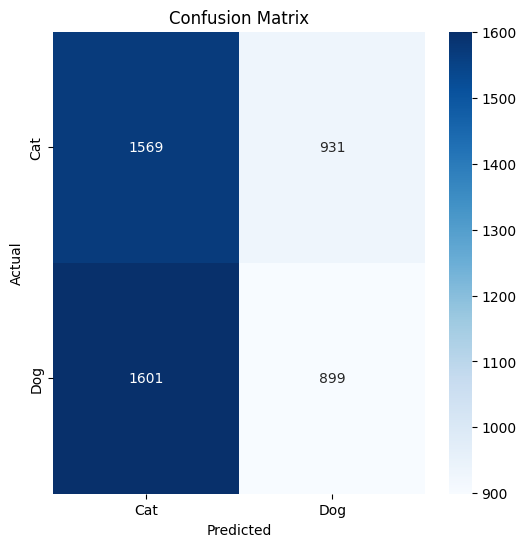

              precision    recall  f1-score   support

         Cat       0.49      0.63      0.55      2500
         Dog       0.49      0.36      0.42      2500

    accuracy                           0.49      5000
   macro avg       0.49      0.49      0.48      5000
weighted avg       0.49      0.49      0.48      5000



In [9]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1️⃣ Tüm validation setini tahmin et
validation_generator.reset()
y_pred = model.predict(validation_generator, steps=validation_generator.samples // validation_generator.batch_size + 1)
y_pred_class = (y_pred > 0.5).astype(int).flatten()

# 2️⃣ Gerçek etiketleri al
y_true = validation_generator.classes

# 3️⃣ Confusion Matrix
cm = confusion_matrix(y_true, y_pred_class)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 4️⃣ Classification Report
print(classification_report(y_true, y_pred_class, target_names=['Cat','Dog']))


Grad-CAM ile Modelin Görsel Açıklamasını İnceleme

Açıklama:
Bu bölümde, modelin bir tahmini yaparken görüntüde hangi bölgelere odaklandığını görselleştirmek için Grad-CAM yöntemi kullanılır. Grad-CAM, özellikle CNN tabanlı sınıflandırma modellerinde, karar verme sürecini yorumlamamıza yardımcı olur.

Adımlar:

1️⃣ Örnek Görüntü Seçimi:

Validation setinden örnek bir görüntü alınır ve modelin beklediği boyuta (150x150) ölçeklenir.

Görüntü array’e dönüştürülür ve normalize edilir.

2️⃣ Modeli Çağırma:

Model bir kez çalıştırılarak input-output yapılandırılır.

3️⃣ Son Conv2D Katmanı Seçimi:

Grad-CAM için son Conv2D katmanı (conv2d_3) hedef alınır.

4️⃣ Grad-CAM Modeli Oluşturma:

Orijinal modelin input’u ile son conv layer ve output’u alan yeni bir model tanımlanır.

5️⃣ Grad-CAM Hesaplama:

Seçilen katmandaki feature map’lerin ağırlıklı ortalaması alınarak heatmap oluşturulur.

Heatmap normalize edilerek 0-1 aralığına getirilir.

6️⃣ Heatmap’i Orijinal Görüntüye Uygulama:

Heatmap, orijinal görüntü boyutuna ölçeklenir.

Görüntü ile heatmap birleştirilir (addWeighted) ve renkli olarak görselleştirilir.

7️⃣ Görselleştirme:

Sonuç, matplotlib ile gösterilir.

Bu sayede modelin hangi bölgeleri dikkate alarak “cat” veya “dog” sınıfını tahmin ettiğini gözlemleyebiliriz.

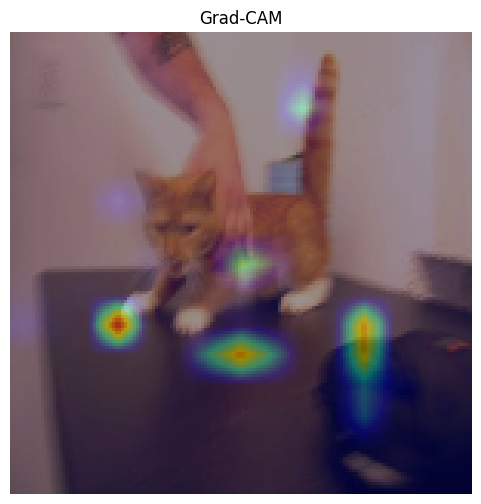

In [13]:
import tensorflow as tf
import cv2
import matplotlib.pyplot as plt
import numpy as np

# 1️⃣ Örnek bir validation görüntüsü al
test_img_path = validation_generator.filepaths[0]  # ilk validation görüntüsü
img = tf.keras.preprocessing.image.load_img(test_img_path, target_size=(150,150))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)/255.0

# 2️⃣ Modeli bir kere çağır (input/output oluşturmak için)
_ = model(img_array)

# 3️⃣ Son Conv2D layer'i seç
last_conv_layer = model.get_layer('conv2d_3')

# 4️⃣ Grad-CAM modeli oluştur
grad_model = tf.keras.models.Model(
    inputs=model.layers[0].input,        # İlk layer input
    outputs=[last_conv_layer.output, model.layers[-1].output]  # Conv layer ve final output
)

# 5️⃣ Grad-CAM hesapla
with tf.GradientTape() as tape:
    conv_outputs, predictions = grad_model(img_array)
    loss = predictions[:,0]

grads = tape.gradient(loss, conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
conv_outputs = conv_outputs[0]

heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
heatmap = np.maximum(heatmap, 0)
heatmap /= tf.reduce_max(heatmap)
heatmap = heatmap.numpy()

# 6️⃣ Orijinal görüntü üzerine uygula
img = cv2.imread(test_img_path)
img = cv2.resize(img, (150,150))
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
heatmap = np.uint8(255*heatmap)
heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

# 7️⃣ Görselleştir
plt.figure(figsize=(6,6))
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Grad-CAM')
plt.show()


Validation Set Üzerinde Performans Değerlendirmesi

Açıklama:
Bu bölümde, eğitilmiş modelin validation (doğrulama) seti üzerindeki performansı ölçülür. Performans ölçümleri, sınıflandırma problemlerinde yaygın olarak kullanılan confusion matrix ve classification report ile yapılır.

Adımlar:

1️⃣ Tahmin Yapma:

Validation generator’dan bir batch görüntü ve etiket alınır.

Model bu görüntüler için tahminler üretir ve 0.5 eşik değeri ile sınıf etiketine dönüştürülür.

2️⃣ Confusion Matrix Oluşturma ve Görselleştirme:

confusion_matrix fonksiyonu ile gerçek ve tahmin edilen etiketler karşılaştırılır.

Seaborn ile ısı haritası şeklinde görselleştirilir.

Bu sayede modelin hangi sınıfları doğru veya yanlış tahmin ettiği kolayca gözlemlenir.

3️⃣ Classification Report:

classification_report ile precision, recall, f1-score ve accuracy gibi metrikler hesaplanır ve sınıflar bazında raporlanır.

Modelin doğruluk ve dengeli tahmin yeteneği değerlendirilir.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


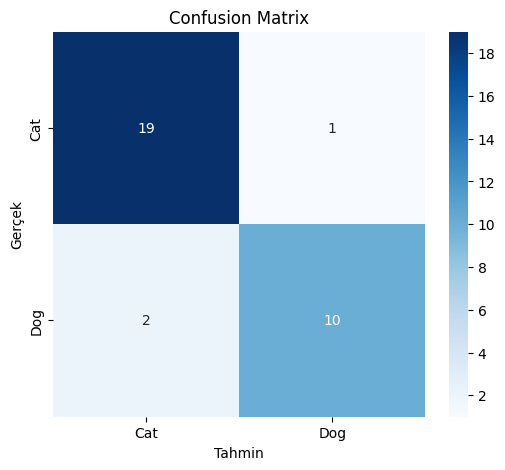

              precision    recall  f1-score   support

         Cat       0.90      0.95      0.93        20
         Dog       0.91      0.83      0.87        12

    accuracy                           0.91        32
   macro avg       0.91      0.89      0.90        32
weighted avg       0.91      0.91      0.91        32



In [14]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# 1️⃣ Validation set üzerinde tahmin yap
val_images, val_labels = next(validation_generator)
preds = model.predict(val_images)
pred_labels = (preds > 0.5).astype(int)

# 2️⃣ Confusion Matrix
cm = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat','Dog'], yticklabels=['Cat','Dog'])
plt.xlabel('Tahmin')
plt.ylabel('Gerçek')
plt.title('Confusion Matrix')
plt.show()

# 3️⃣ Classification Report
print(classification_report(val_labels, pred_labels, target_names=['Cat','Dog']))


Modelin Öğrenme Hızını Değiştirerek Yeniden Eğitilmesi

Açıklama:
Bu bölümde, modelin eğitim sürecinde learning rate (öğrenme hızı) değiştirilerek modelin performansını iyileştirme amaçlanır. Learning rate, modelin ağırlık güncellemelerinin büyüklüğünü belirler; çok yüksek veya çok düşük olması öğrenmeyi olumsuz etkileyebilir.

Adımlar:

1️⃣ Modelin Yeniden Derlenmesi:

Adam optimizasyon algoritması kullanılır ve learning rate 5e-5 olarak ayarlanır.

Kayıp fonksiyonu olarak binary_crossentropy, performans metriği olarak accuracy seçilir.

2️⃣ Modelin Yeniden Eğitilmesi:

fit fonksiyonu ile model tekrar eğitilir.

Training ve validation generator’ları kullanılır, batch sayısı ve epoch sayısı ayarlanır.

Bu sayede model daha düşük bir öğrenme hızıyla daha dengeli bir şekilde optimize edilir.

In [15]:
from tensorflow.keras.optimizers import Adam

# Yeni model ile learning_rate değişikliği
model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=5e-5),
    metrics=['accuracy']
)

# Yeniden eğit
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10
)


Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 237ms/step - accuracy: 0.8627 - loss: 0.3120 - val_accuracy: 0.8642 - val_loss: 0.3095
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 233ms/step - accuracy: 0.8742 - loss: 0.2964 - val_accuracy: 0.8722 - val_loss: 0.2993
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 233ms/step - accuracy: 0.8695 - loss: 0.2995 - val_accuracy: 0.8782 - val_loss: 0.2857
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 149s 239ms/step - accuracy: 0.8757 - loss: 0.2926 - val_accuracy: 0.8744 - val_loss: 0.2929
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 148s 236ms/step - accuracy: 0.8772 - loss: 0.2834 - val_accuracy: 0.8816 - val_loss: 0.2759
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 144s 230ms/step - accuracy: 0.8777 - loss: 0.2902 - val_accuracy: 0.8752 - val_loss: 0.2916
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 145s 231ms/step - accuracy: 0.8801 - loss: 0.2791 - val_accuracy: 0.8772 - val_loss: 0.2846
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 142s 227ms/step - accuracy: 0.8847 -

**OPSİYONEL İŞLEMLER**

**TensorBoard ile eğitim izleme**

Açıklama:
Bu bölümde, modelin eğitim sürecini TensorBoard kullanarak görselleştirmek amaçlanır. TensorBoard, loss, accuracy ve diğer metriklerin eğitim sırasında nasıl değiştiğini takip etmeye olanak sağlar.

Adımlar:

1️⃣ TensorBoard Callback Oluşturma:

TensorBoard callback’i için log dizini, tarih ve saat ile benzersiz bir şekilde oluşturulur.

histogram_freq=1 parametresi, her epoch sonunda ağırlık histogramlarını kaydeder.

2️⃣ Modeli Callback ile Eğitme:

fit fonksiyonu çağrılırken callbacks parametresine TensorBoard callback’i eklenir.

Bu sayede eğitim sırasında metrikler ve ağırlık değişimleri TensorBoard üzerinden görselleştirilebilir.

In [16]:
from tensorflow.keras.callbacks import TensorBoard
import datetime

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Modeli tekrar eğitirken callback ekle
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=20,
    callbacks=[tensorboard_callback]
)


Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 170s 270ms/step - accuracy: 0.8829 - loss: 0.2710 - val_accuracy: 0.8806 - val_loss: 0.2856
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 166s 266ms/step - accuracy: 0.8848 - loss: 0.2656 - val_accuracy: 0.8932 - val_loss: 0.2575
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 262ms/step - accuracy: 0.8872 - loss: 0.2697 - val_accuracy: 0.8828 - val_loss: 0.2825
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 164s 262ms/step - accuracy: 0.8854 - loss: 0.2643 - val_accuracy: 0.8864 - val_loss: 0.2733
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 162s 260ms/step - accuracy: 0.8898 - loss: 0.2567 - val_accuracy: 0.8968 - val_loss: 0.2492
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 158s 252ms/step - accuracy: 0.8944 - loss: 0.2515 - val_accuracy: 0.8882 - val_loss: 0.2670
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 254ms/step - accuracy: 0.8961 - loss: 0.2472 - val_accuracy: 0.8838 - val_loss: 0.2755
Epoch 8/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 159s 255ms/step - accuracy: 0.8946 -

**Test seti üzerinden değerlendirme**

Açıklama:
Bu bölümde, önceden eğitilmiş model test veri seti üzerinde değerlendirilir. Test seti model tarafından daha önce görülmemiş verileri içerir ve modelin genelleme performansını ölçmek için kullanılır.

Adımlar:

1️⃣ Test Verisi İçin Data Generator Oluşturma:

ImageDataGenerator ile test görüntüleri normalize edilir (rescale=1./255).

flow_from_directory fonksiyonu ile test klasörü okunur, shuffle kapatılır (shuffle=False) çünkü sıralamayı korumak önemlidir.

2️⃣ Model ile Tahmin Yapma:

predict fonksiyonu kullanılarak test görüntüleri için olasılık tahminleri (y_pred_prob) alınır.

Olasılıklar 0.5 eşik değeri ile binary sınıflara (y_pred) dönüştürülür.

3️⃣ Performans Değerlendirmesi:

confusion_matrix ve classification_report ile modelin precision, recall, f1-score ve accuracy değerleri hesaplanır ve sınıflar bazında değerlendirilir.

In [18]:
# Test generator
test_datagen = ImageDataGenerator(rescale=1./255)
test_dir = '/kaggle/working/test'  
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# Tahmin
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix ve Classification Report
print(confusion_matrix(test_generator.classes, y_pred))
print(classification_report(test_generator.classes, y_pred))


Found 12500 images belonging to 1 classes.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 46ms/step
[[5360 7140]
 [   0    0]]
              precision    recall  f1-score   support

           0       1.00      0.43      0.60     12500
           1       0.00      0.00      0.00         0

    accuracy                           0.43     12500
   macro avg       0.50      0.21      0.30     12500
weighted avg       1.00      0.43      0.60     12500



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Ek veri augmentasyonu**

Açıklama:
Bu kod bloğunda, eğitim veri seti için gelişmiş veri artırma (data augmentation) uygulanır. Veri artırma, modelin genelleme yeteneğini artırmak ve overfitting’i azaltmak için kullanılır.

Adımlar ve Parametreler:

rescale=1./255: Piksel değerlerini 0–1 aralığına normalize eder.

rotation_range=40: Görseller rastgele ±40 derece döndürülür.

width_shift_range=0.2, height_shift_range=0.2: Görseller yatay ve dikey olarak %20 kaydırılır.

shear_range=0.2: Shear transformasyonu uygulanır.

zoom_range=0.2: Görseller %20 oranında yakınlaştırılır veya uzaklaştırılır.

horizontal_flip=True: Görseller yatay olarak rastgele çevrilir.

brightness_range=[0.8,1.2]: Görsellerin parlaklığı rastgele ayarlanır (opsiyonel ekleme).

fill_mode='nearest': Transformasyon sonucu oluşan boş pikseller en yakın komşu piksellerle doldurulur.

validation_split=0.2: Eğitim setinin %20’si doğrulama (validation) için ayrılır.

In [28]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    brightness_range=[0.8,1.2],  # opsiyonel ekleme
    fill_mode='nearest',
    validation_split=0.2
)


**Hiperparametre optimizasyonu**

Açıklama:
Bu kod bloğunda, modelin performansını artırmak için hiperparametre optimizasyonu yapılır. Keras Tuner kullanılarak, farklı konvolüsyon filtre sayıları ve öğrenme oranları denenebilir.

Adımlar ve Açıklamalar:

hp.Int('conv_1_filter', 32, 128, step=32): İlk Conv2D katmanındaki filtre sayısını 32’den 128’e kadar adım adım denemek için hiperparametre tanımlanır.

hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4]): Farklı öğrenme oranları (learning rate) için seçim yapılır.

Sequential model: Standart CNN yapısı oluşturulur.

Flatten + Dense(512, activation='relu') + Dense(1, activation='sigmoid'): Binary sınıflandırma için tam bağlantılı katmanlar eklenir.

compile: Model, seçilen hiperparametrelerle derlenir (optimizer, loss, metrics).

In [29]:
from kerastuner.tuners import RandomSearch
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers, models

def build_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', 32, 128, step=32),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(150,150,3)
    ))
    # Diğer katmanlar benzer şekilde hp ile
    model.add(layers.Flatten())
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

# RandomSearch veya GridSearch ile tuner tanımlanabilir


/tmp/ipykernel_36/195994895.py:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [35]:
def build_model(hp):
    model = models.Sequential()
    
    # Conv Layer 1
    model.add(layers.Conv2D(
        filters=hp.Int('conv_1_filter', 32, 64, step=32),
        kernel_size=(3,3),
        activation='relu',
        input_shape=(150,150,3)
    ))
    model.add(layers.MaxPooling2D(2,2))
    
    # Conv Layer 2
    model.add(layers.Conv2D(
        filters=hp.Int('conv_2_filter', 32, 128, step=32),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(2,2))
    
    # Conv Layer 3
    model.add(layers.Conv2D(
        filters=hp.Int('conv_3_filter', 64, 128, step=32),
        kernel_size=(3,3),
        activation='relu'
    ))
    model.add(layers.MaxPooling2D(2,2))
    
    # Flatten ve Dropout
    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    
    # Daha küçük Dense katmanı
    model.add(layers.Dense(hp.Int('dense_units', 128, 256, step=64), activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(
        optimizer=Adam(hp.Choice('learning_rate', [1e-3, 5e-4, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [36]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,            # Hafif denemeler
    executions_per_trial=1,  # Her trial için 1 kez çalıştır
    directory='ktuner',
    project_name='dogs_vs_cats'
)

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=5                  # Kısa epoch ile test
)


Trial 5 Complete [00h 13m 40s]
val_accuracy: 0.760200023651123

Best val_accuracy So Far: 0.7613999843597412
Total elapsed time: 01h 06m 18s
